In [1]:
import numpy as np
import matplotlib.pyplot as plt

from floortrans.loaders import FloorplanSVG
from floortrans.loaders.augmentations import (RandomCropToSizeTorch,
                                              ResizePaddedTorch,
                                              Compose,
                                              DictToTensor,
                                              ColorJitterTorch,
                                              RandomRotations)

from torchinfo import summary

from model.deeplabv3plus import DeepLabV3Plus

# Loading the Data

In [2]:
DATA_PATH = 'data/cubicasa5k/'
TRAIN_PATH = 'train.txt'
VAL_PATH = 'val.txt'

aug = Compose([
    ResizePaddedTorch((0, 0), data_format='dict', size=(512, 512)),
    DictToTensor()
])

train_data = FloorplanSVG(DATA_PATH, TRAIN_PATH, augmentations=aug, format='lmdb')

In [3]:
print('Image Shape:', train_data[0]['image'].shape)
print('Label Shape:', train_data[0]['label'].shape)


Image Shape: torch.Size([3, 512, 512])
Label Shape: torch.Size([23, 512, 512])


# Visualizing Samples

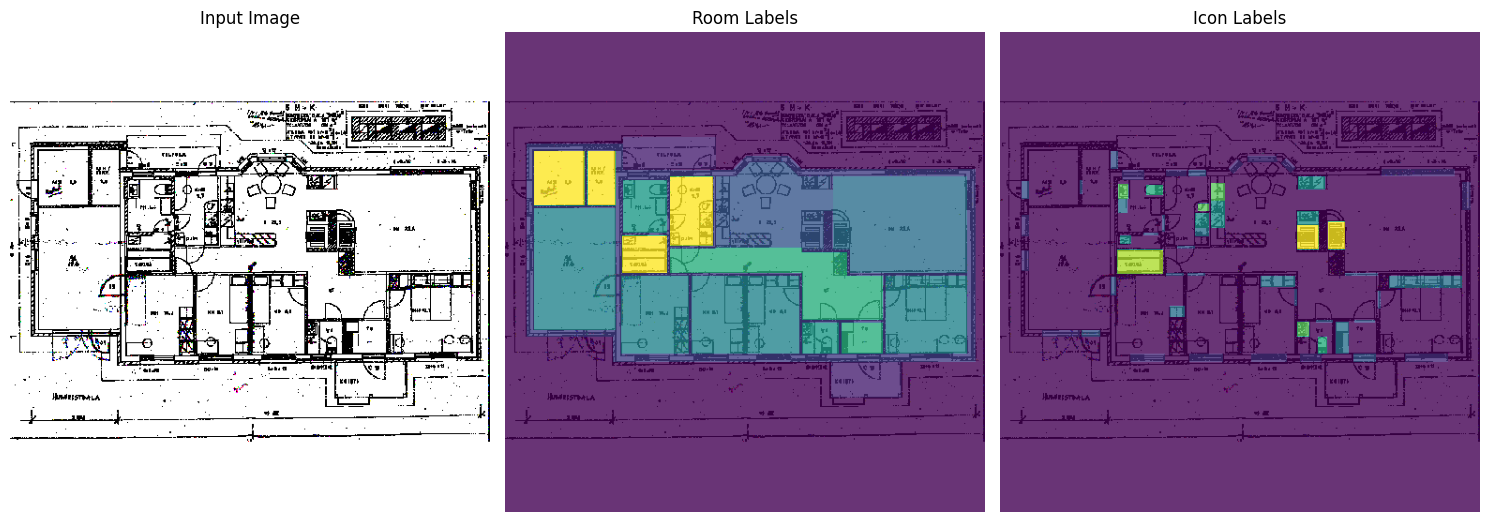

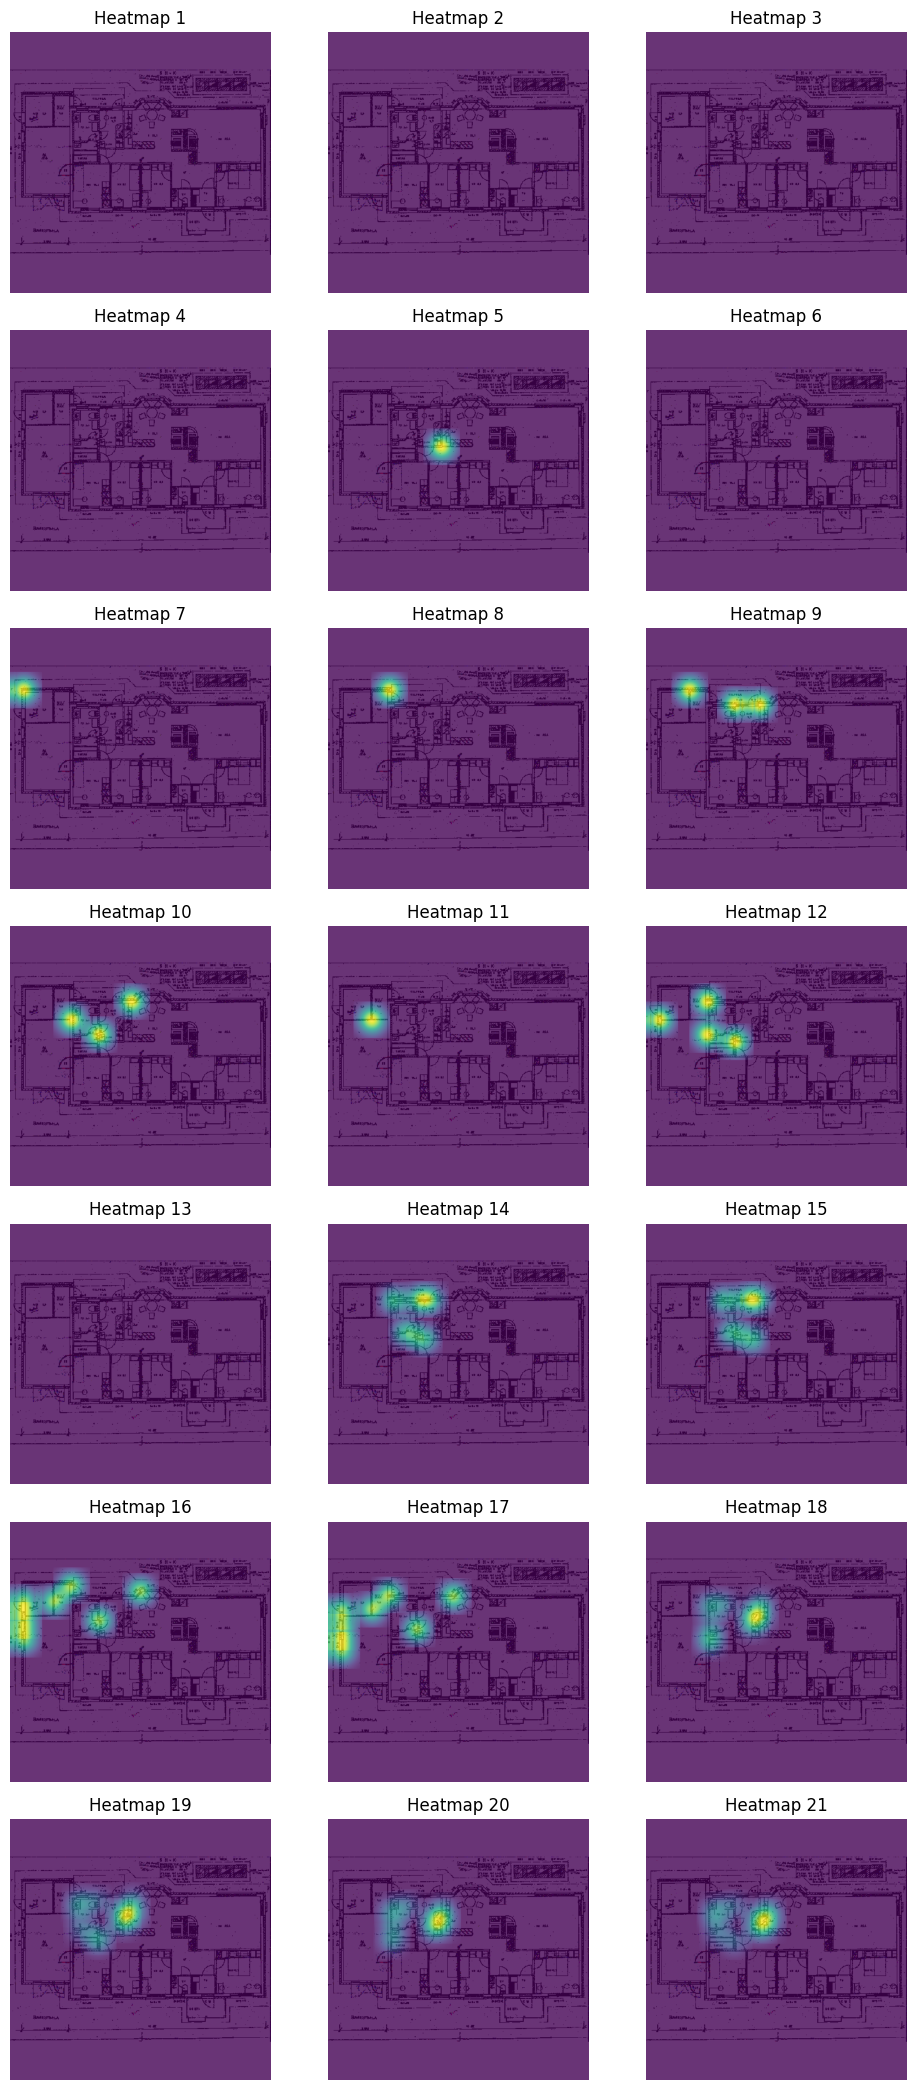

In [4]:
sample = train_data[10]

# Convert back to [0, 255] range
tensor_image = sample['image'] * 255.0

np_image = tensor_image.numpy().astype(np.uint8)  # Convert to unsigned 8-bit integer

# Transpose to [H, W, 3] from [3, H, W]
np_image = np.transpose(np_image, (1, 2, 0))

# Create figure with 1 row and 3 columns for the first set of visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# Input image
axes[0].imshow(np_image)
axes[0].axis('off')
axes[0].set_title('Input Image')

# Room segmentation map
axes[1].imshow(np_image)
axes[1].imshow(sample['label'][21], alpha=0.8)
axes[1].axis('off')
axes[1].set_title('Room Labels')

# Icon segmentation map
axes[2].imshow(np_image)
axes[2].imshow(sample['label'][22], alpha=0.8)
axes[2].axis('off')
axes[2].set_title('Icon Labels')

plt.tight_layout()
plt.show()

# Now display the heatmaps, 3 heatmaps per row
num_heatmaps = 21
cols = 3
rows = (num_heatmaps + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

for i in range(num_heatmaps):
    row = i // cols
    col = i % cols

    axes[row, col].imshow(np_image)
    axes[row, col].imshow(sample['label'][i], alpha=0.8)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Heatmap {i+1}')

# If there are empty spaces in the last row (if heatmaps < total subplots), hide them
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])  # Remove unused subplots

plt.tight_layout()
plt.show()


In [1]:
from model.deeplabv3plus import DeepLabV3Plus
from torchinfo import summary

model = DeepLabV3Plus(backbone='mobilenet_v2', attention=False).to('cuda')

summary(model, input_size=(32, 3, 256, 256), device='cuda')

Layer (type:depth-idx)                                       Output Shape              Param #
DeepLabV3Plus                                                [32, 12, 256, 256]        --
├─Backbone: 1-1                                              [32, 24, 64, 64]          --
│    └─MobileNetV2: 2-1                                      --                        1,281,000
│    │    └─Sequential: 3-1                                  --                        2,223,872
├─ASPP: 1-2                                                  [32, 256, 8, 8]           --
│    └─Conv2d: 2-2                                           [32, 256, 8, 8]           327,680
│    └─AtrousConv: 2-3                                       [32, 256, 8, 8]           --
│    │    └─DepthwiseSeparableConv: 3-2                      [32, 256, 8, 8]           339,712
│    └─AtrousConv: 2-4                                       [32, 256, 8, 8]           --
│    │    └─DepthwiseSeparableConv: 3-3                      [32, 256, 

In [3]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).to('cuda')

summary(model, input_size=(32, 3, 256, 256), device='cuda')

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [32, 1000]                --
├─Sequential: 1-1                                  [32, 1280, 8, 8]          --
│    └─Conv2dNormActivation: 2-1                   [32, 32, 128, 128]        --
│    │    └─Conv2d: 3-1                            [32, 32, 128, 128]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 128, 128]        64
│    │    └─ReLU6: 3-3                             [32, 32, 128, 128]        --
│    └─InvertedResidual: 2-2                       [32, 16, 128, 128]        --
│    │    └─Sequential: 3-4                        [32, 16, 128, 128]        896
│    └─InvertedResidual: 2-3                       [32, 24, 64, 64]          --
│    │    └─Sequential: 3-5                        [32, 24, 64, 64]          5,136
│    └─InvertedResidual: 2-4                       [32, 24, 64, 64]          --
│    │    └─Sequential: 3-6   